In [8]:
# IMPORTS & SETUP

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                   GridSearchCV, cross_validate)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, accuracy_score, 
                           confusion_matrix, ConfusionMatrixDisplay,
                           precision_recall_curve, RocCurveDisplay,
                           roc_auc_score, roc_curve)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [9]:
# DATA PREPROCESSING

# Load and clean data
data = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
df_unique = data.drop_duplicates()

# Convert timestamps
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])

# Standardize text
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()

In [10]:
# FEATURE ENGINEERING
class RequestRateFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['src_ip', 'time'])

        # Set time as datetime index temporarily
        X['time'] = pd.to_datetime(X['time'])
        X.set_index('time', inplace=True)

        # Calculate number of requests in the past 5 minutes
        X['requests_5min'] = (
            X.groupby('src_ip')['src_ip']
             .rolling('5min', closed='left')
             .count()
             .reset_index(level=0, drop=True)
        )

        # Reset index to get 'time' back as a column
        X = X.reset_index()

        # Calculate request acceleration
        X['request_accel'] = X.groupby('src_ip')['requests_5min'].diff()

        # Calculate number of requests in the last 1 minute
        X.set_index('time', inplace=True)
        X['requests_1min'] = (
            X.groupby('src_ip')['src_ip']
             .rolling('1min', closed='left')
             .count()
             .reset_index(level=0, drop=True)
        )

        # Reset index again
        X = X.reset_index()

        # Fill NaNs with 0
        X[['requests_5min', 'request_accel', 'requests_1min']] = X[['requests_5min', 'request_accel', 'requests_1min']].fillna(0)

        return X



df_unique = RequestRateFeatures().fit_transform(df_unique)

# Add key features
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()
df_unique['is_suspicious'] = (df_unique['detection_types'] == 'waf_rule').astype(int)
df_unique['detection_latency'] = (df_unique['time'] - df_unique['creation_time']).dt.total_seconds()



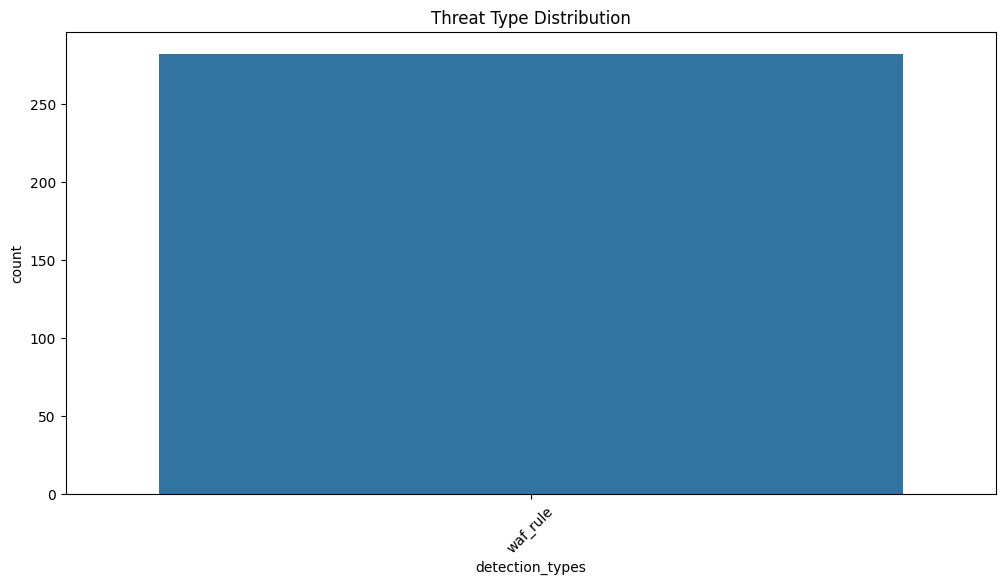

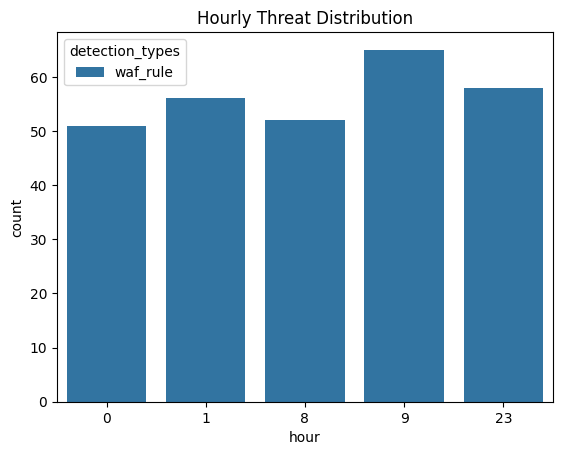

In [11]:
# EDA VISUALIZATIONS

# Threat distribution
plt.figure(figsize=(12,6))
sns.countplot(data=df_unique, x='detection_types')
plt.title('Threat Type Distribution')
plt.xticks(rotation=45)
plt.show()

# Temporal patterns
df_unique['hour'] = df_unique['time'].dt.hour
sns.countplot(data=df_unique, x='hour', hue='detection_types')
plt.title('Hourly Threat Distribution')
plt.show()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 282 non-null    datetime64[ns, UTC]
 1   bytes_in             282 non-null    int64              
 2   bytes_out            282 non-null    int64              
 3   creation_time        282 non-null    datetime64[ns, UTC]
 4   end_time             282 non-null    datetime64[ns, UTC]
 5   src_ip               282 non-null    object             
 6   src_ip_country_code  282 non-null    object             
 7   protocol             282 non-null    object             
 8   response.code        282 non-null    int64              
 9   dst_port             282 non-null    int64              
 10  dst_ip               282 non-null    object             
 11  rule_names           282 non-null    object             
 12  observat

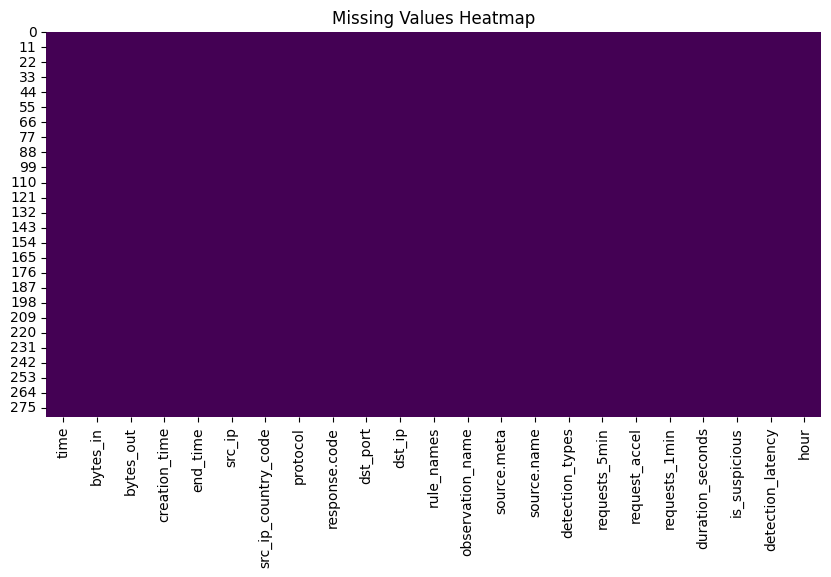

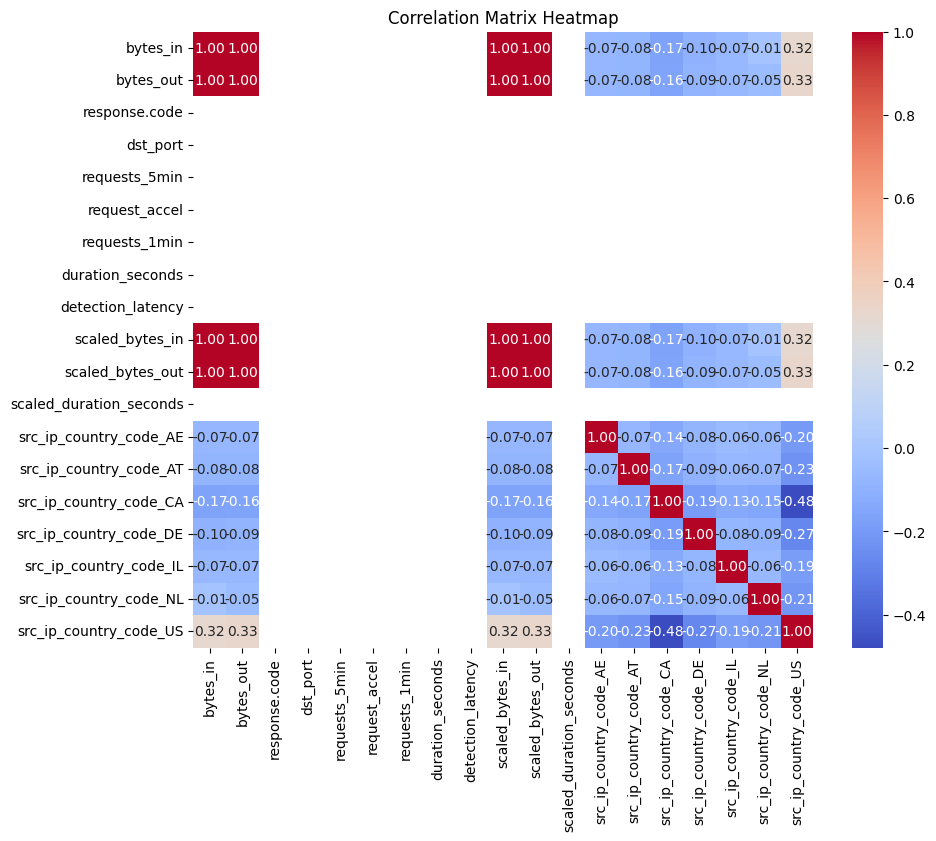

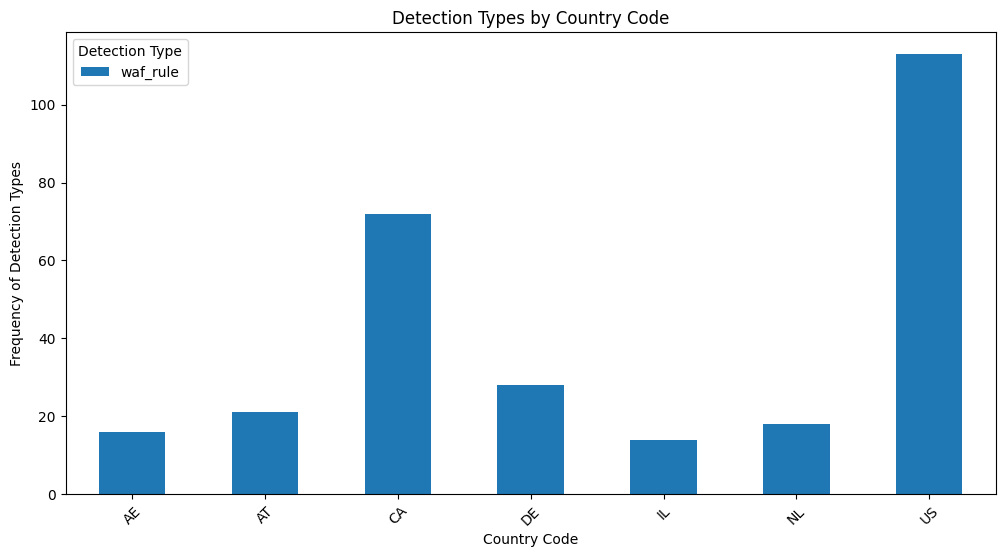

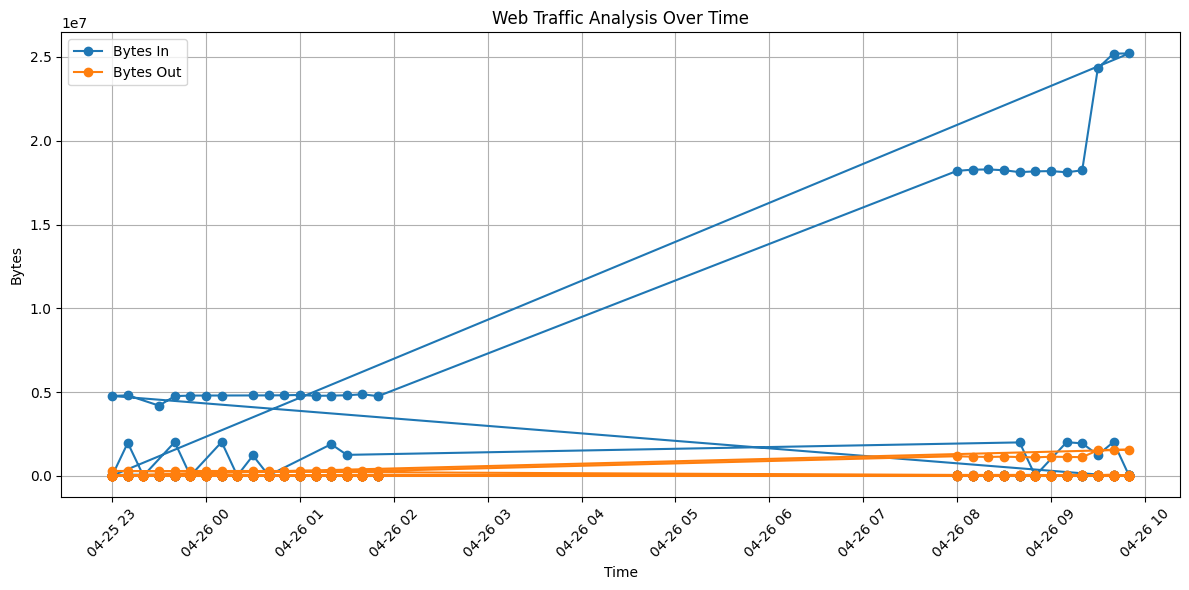

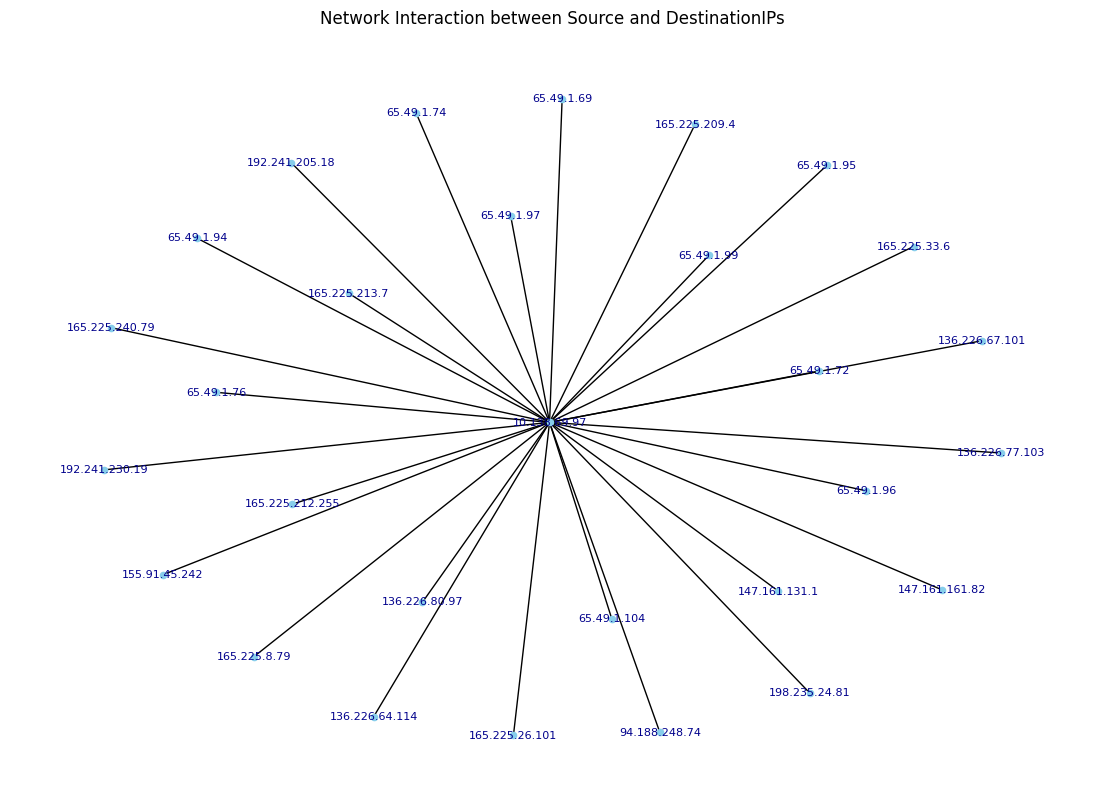

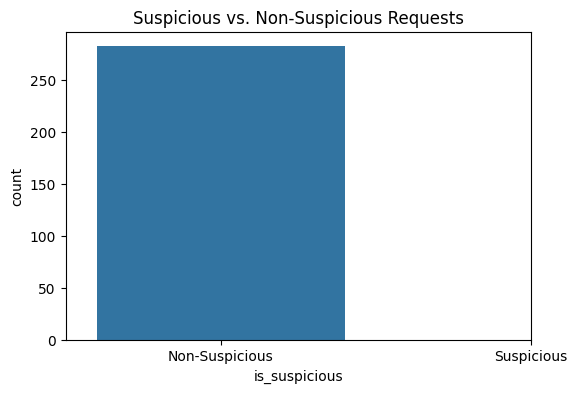


 Target Distribution:
is_suspicious
1    1.0
Name: proportion, dtype: float64


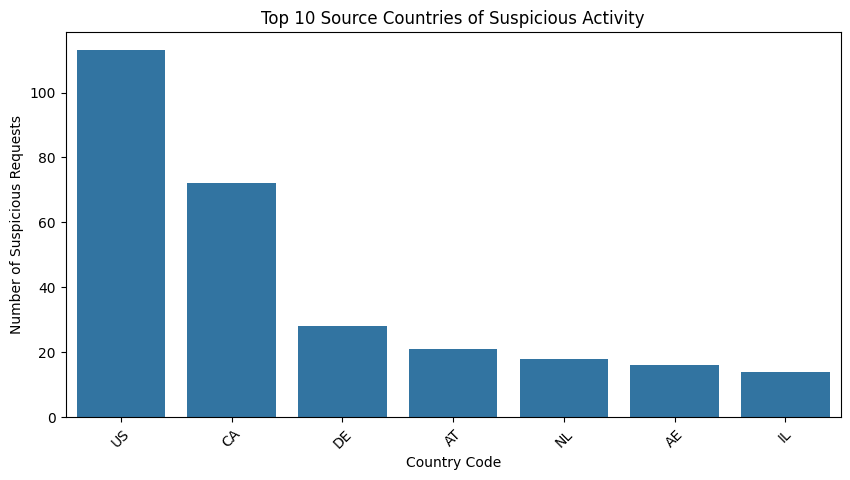

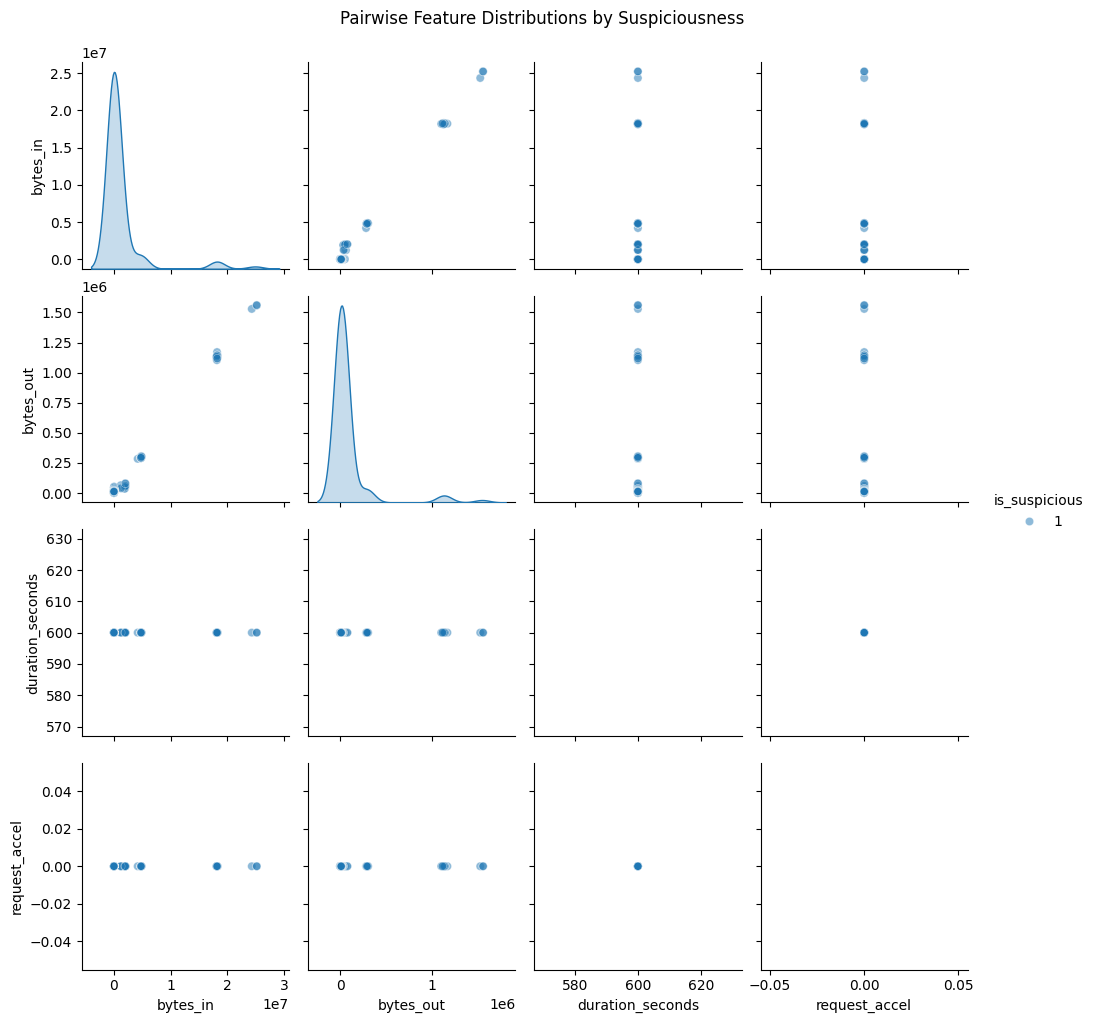

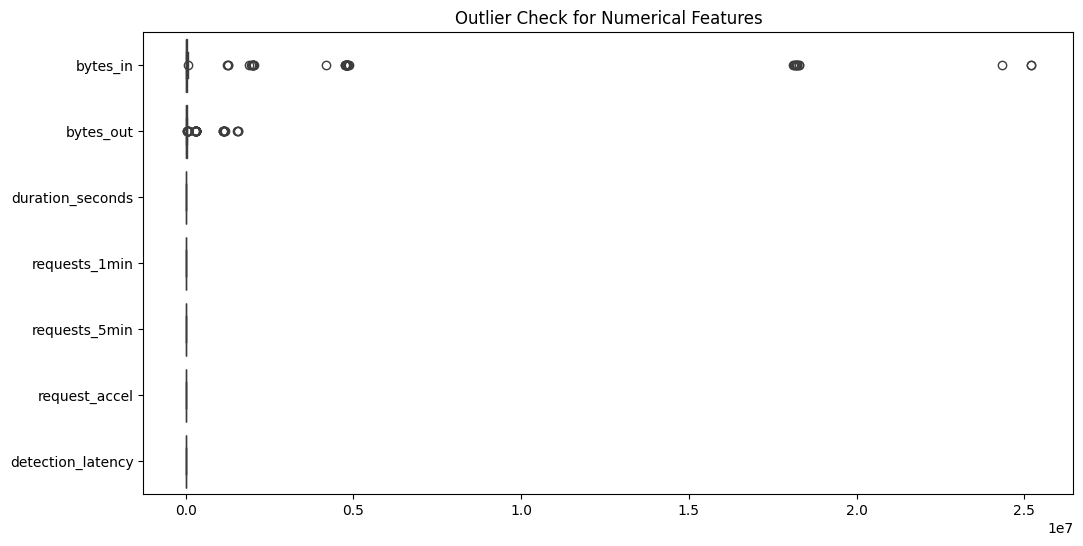

EDA Completed.


In [12]:
# OneHotEncoder for categorical features (use sparse_output=False for newer sklearn)
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])

# StandardScaler for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in','bytes_out', 'duration_seconds']])

# Combining transformed features back into the DataFrame
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out','scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

scaled_df = pd.DataFrame(scaled_features,columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features,columns=encoded_columns, index=df_unique.index)

# Concatenate all the data back together
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)
 # Displaying the transformed data
transformed_df.head()

 # Compute correlation matrix for numeric columns only
numeric_df = transformed_df.select_dtypes(include=['float64','int64'])
correlation_matrix_numeric = numeric_df.corr()

def run_eda(df):
    # Convert 'time' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    
    print("Dataset Info:")
    print(df.info())
    
    print("\nSummary Statistics:")
    print(df.describe())

    # Missing values heatmap
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap")
    plt.show()

    # heatmap for the correlation matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(correlation_matrix_numeric,annot=True,fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')

    # Stacked Bar Chart for Detection Types by Country
    # Preparing data for stacked bar chart
    detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'],transformed_df['detection_types'])
    detection_types_by_country.plot(kind='bar', stacked=True,figsize=(12, 6))
    plt.title('Detection Types by Country Code')
    plt.xlabel('Country Code')
    plt.ylabel('Frequency of Detection Types')
    plt.xticks(rotation=45)
    plt.legend(title='Detection Type')
    plt.show()

    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)

        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['bytes_in'], label='Bytes In', marker='o')
        plt.plot(df.index, df['bytes_out'], label='Bytes Out', marker='o')
        plt.title('Web Traffic Analysis Over Time')
        plt.xlabel('Time')
        plt.ylabel('Bytes')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Column 'time' not found for time series plot.")
      
    # Create a graph
    G = nx.Graph()
    # Add edges from source IP to destination IP
    for idx, row in data.iterrows():
        G.add_edge(row['src_ip'], row['dst_ip'])
    
    # Draw the network graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx(G, with_labels=True, node_size=20,font_size=8, node_color='skyblue', font_color='darkblue')
    plt.title('Network Interaction between Source and DestinationIPs')
    plt.axis('off') # Turn off the axis
    plt.show()
   
    # Target distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='is_suspicious', data=df)
    plt.title('Suspicious vs. Non-Suspicious Requests')
    plt.xticks([0, 1], ['Non-Suspicious', 'Suspicious'])
    plt.show()

    print("\n Target Distribution:")
    print(df['is_suspicious'].value_counts(normalize=True))

    # Numerical feature correlation
    numerical_features = ['bytes_in', 'bytes_out', 'duration_seconds', 
                          'requests_1min', 'requests_5min', 'request_accel', 
                          'detection_latency']
 
    

    # Trend of suspicious requests
    # Top source countries
    top_countries = df[df['is_suspicious'] == 1]['src_ip_country_code'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_countries.index, y=top_countries.values)
    plt.title("Top 10 Source Countries of Suspicious Activity")
    plt.ylabel("Number of Suspicious Requests")
    plt.xlabel("Country Code")
    plt.xticks(rotation=45)
    plt.show()

    # Pairplot
    sns.pairplot(df, vars=['bytes_in', 'bytes_out', 'duration_seconds', 'request_accel'], 
                 hue='is_suspicious', diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.suptitle("Pairwise Feature Distributions by Suspiciousness", y=1.02)
    plt.show()

    # Outlier detection
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[numerical_features], orient='h')
    plt.title("Outlier Check for Numerical Features")
    plt.show()

    print("EDA Completed.")


run_eda(df_unique)



In [13]:
#MODEL PIPELINES
# Features and target
X = df_unique[['bytes_in', 'bytes_out', 'duration_seconds', 
              'requests_1min', 'requests_5min', 'request_accel',
              'src_ip_country_code']]
y = df_unique['is_suspicious']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bytes_in', 'bytes_out', 'duration_seconds',
                                 'requests_1min', 'requests_5min', 'request_accel']),
        ('cat', OneHotEncoder(), ['src_ip_country_code'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [14]:
# First check class distribution
print("Class distribution in full dataset:", y.value_counts())
print("Class distribution in training set:", y_train.value_counts())

# Modified pipeline with SMOTE safety check
class SafeSMOTE:
    def fit_resample(self, X, y):
        if len(np.unique(y)) > 1:  # Only apply SMOTE if multiple classes exist
            return SMOTE(random_state=42).fit_resample(X, y)
        return X, y

# Updated pipeline
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SafeSMOTE()),  # Use our safe wrapper
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

# Reduce parameter grid for faster testing
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,  # Reduced folds for speed
    scoring='f1',
    error_score='raise'
)

# Now fit the model
try:
    rf_grid.fit(X_train, y_train)
except ValueError as e:
    print(f"Model fitting failed: {str(e)}")
    print("This suggests your training data still has only one class")
    print("Try collecting more data or adjusting your train/test split")


best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)

probs = best_rf.predict_proba(X_test)
if probs.shape[1] == 2:
    y_probs = probs[:, 1]
else:
    print("Only one class seen by classifier during training.")
    class_seen = best_rf.classes_[0]
    y_probs = np.ones_like(y_test, dtype=float) if class_seen == 1 else np.zeros_like(y_test, dtype=float)

print("Best Parameters:", rf_grid.best_params_)
print(classification_report(y_test, y_pred))

# Safe ROC-AUC calculation
if len(np.unique(y_test)) < 2:
    print("ROC-AUC not defined: only one class present in y_test.")
    roc_auc = None
else:
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"ROC-AUC: {roc_auc:.4f}")


Class distribution in full dataset: is_suspicious
1    282
Name: count, dtype: int64
Class distribution in training set: is_suspicious
1    197
Name: count, dtype: int64
Only one class seen by classifier during training.
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

ROC-AUC not defined: only one class present in y_test.


In [15]:




#NEURAL NETWORK (WITH SAFE CLASS WEIGHTS)
# Preprocess data
from tensorflow.keras.callbacks import EarlyStopping

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get ACTUAL class labels present in y_train
unique_classes = np.unique(y_train)
print("Classes present in y_train:", unique_classes)

# SAFE class weight calculation
if len(unique_classes) == 1:
    print("Warning: Only one class present in y_train. Setting uniform weights.")
    class_weights = {unique_classes[0]: 1.0}  # Single class gets weight 1.0
else:
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=y_train
    )
    class_weights = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

print("Class weights:", class_weights)

# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Only use class_weight if we have both classes
fit_kwargs = {'class_weight': class_weights} if len(unique_classes) > 1 else {}

history = model.fit(
    X_train_preprocessed, 
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1,
    **fit_kwargs  # Conditionally adds class_weight
)

# Evaluate
nn_loss, nn_accuracy = model.evaluate(X_test_preprocessed, y_test)
print(f"\nNeural Network Test Accuracy: {nn_accuracy*100:.2f}%")
print(f"Test Loss: {nn_loss:.4f}")

Classes present in y_train: [1]
Class weights: {1: 1.0}
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8281 - loss: 0.6190 - val_accuracy: 1.0000 - val_loss: 0.5131
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.4514 - val_accuracy: 1.0000 - val_loss: 0.3889
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3579 - val_accuracy: 1.0000 - val_loss: 0.2778
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.2607 - val_accuracy: 1.0000 - val_loss: 0.1854
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.1787 - val_accuracy: 1.0000 - val_loss: 0.1155
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1143 - val_accuracy: 1.0000 - val_loss: 0.0680
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 0.0392
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - los

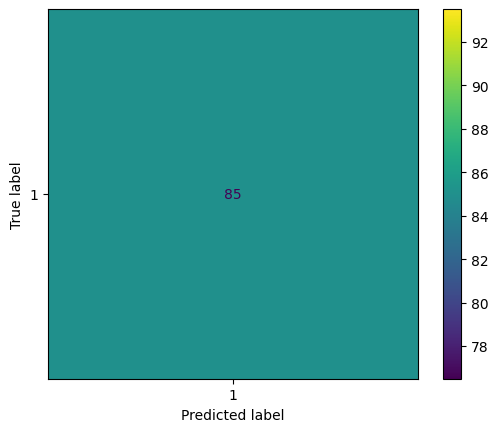

Optimal Threshold: 1.0000


In [40]:
# OPERATIONAL METRICS
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.show()

# Cost-benefit analysis
FP_COST = 100  
FN_COST = 5000  

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
total_costs = []
for threshold in thresholds:
    preds = (y_probs >= threshold).astype(int)
    fp = ((preds == 1) & (y_test == 0)).sum()
    fn = ((preds == 0) & (y_test == 1)).sum()
    total_costs.append((fp * FP_COST) + (fn * FN_COST))

optimal_idx = np.argmin(total_costs)
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")